# Load and Poison Data

In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from config import DATA_PATH

import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.classifiers import KerasClassifier
from art.utils import load_mnist_raw, preprocess
from art.poison_detection import ActivationDefense
from examples.mnist_poison_detection import generate_backdoor

### Load MNIST data and take a random sample to reduce runtime

In [19]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist_raw()

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

### Poison training data

In [20]:
# Poison training data
percent_poison = .33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = generate_backdoor(x_raw, y_raw, percent_poison)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)


### Poison test data

In [21]:
# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = generate_backdoor(x_raw_test, y_raw_test, percent_poison)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

### Shuffle training data

In [22]:
# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]

x_poisoned_raw = x_poisoned_raw[shuffled_indices]
y_poisoned_raw = y_poisoned_raw[shuffled_indices]

# Specify and train model

In [23]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
k.set_learning_phase(1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
classifier = KerasClassifier((min_, max_), model=model)

classifier.fit(x_train, y_train, nb_epochs=5, batch_size=128)

Epoch 1/5
88/87 [==============================] - 14s 160ms/step - loss: 1.2624 - acc: 0.5432
Epoch 2/5
88/87 [==============================] - 15s 166ms/step - loss: 0.4085 - acc: 0.8724
Epoch 3/5
88/87 [==============================] - 15s 175ms/step - loss: 0.2569 - acc: 0.9248
Epoch 4/5
88/87 [==============================] - 15s 176ms/step - loss: 0.1969 - acc: 0.9382
Epoch 5/5
88/87 [==============================] - 16s 177ms/step - loss: 0.1527 - acc: 0.9532


# Evaluate model and show classification samples

### Evaluation on clean test samples

In [25]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))


Clean test set accuracy: 94.42%


### Display and classify clean test sample

In [26]:
# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

# random_clean = np.random.randint(clean_total)
# clean_img = x_test[is_poison_test == 0][random_clean].squeeze()
# plt.imshow(clean_img)
# plt.show()
# clean_label = y_test[is_poison_test == 0][random_clean]
# print("Label: " + str(np.argmax(clean_label)))
# print("Prediction: " + str(clean_preds[random_clean]))

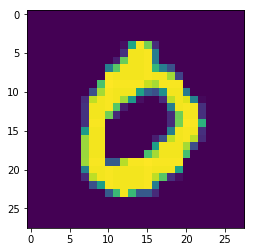

Prediction: 0


In [27]:
# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### Evaluate model on poisoned test samples

In [28]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

poison_acc = poison_correct / poison_total
print("\nPoisonous test set accuracy (i.e. effectiveness of poison): %.2f%%" % (poison_acc * 100))


Poisonous test set accuracy (i.e. effectiveness of poison): 91.41%


### Display and classify poisoned test sample

In [29]:
# Display image, label, and prediction for a poisoned image to see the backdoor working

# random_poison = np.random.randint(poison_total)
# poison_img = x_test[is_poison_test][random_poison].squeeze()
# plt.imshow(poison_img)
# plt.show()
# poison_label = y_test[is_poison_test][random_poison]
# print("Poisoned label: " + str(np.argmax(poison_label)))
# print("Prediction: " + str(poison_preds[random_poison]))

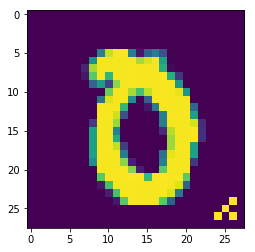

Prediction: 1


In [30]:
# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

### Evaluate accuracy on entire test set

In [31]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\nOverall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))



Overall test set accuracy (i.e. effectiveness of poison): 93.43%


# Detect Poison using Activation Defense

In [34]:
defense = ActivationDefense(classifier, x_train, y_train)

In [37]:
confidence_level, is_clean_lst = defense.detect_poison(n_clusters=2,
                                                       ndims=10,
                                                       reduce="PCA")
print("Analysis completed")

Analysis completed


# Evaluate Results

In [43]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defense.evaluate_defense(is_clean)
# print("Evaluation defense results: ")
# import pprint
# pprint.pprint(confusion_matrix)

------------------- Results using size metric -------------------

Error rates per class:
-------------------0---------------
true-positive rate: 365/365=100
true-negative rate: 740/742=99.7
false-positive rate: 2/742=0.27
false-negative rate: 0/365=0
-------------------1---------------
true-positive rate: 413/426=96.9
true-negative rate: 865/865=100
false-positive rate: 0/865=0
false-negative rate: 13/426=3.05
-------------------2---------------
true-positive rate: 363/364=99.7
true-negative rate: 728/739=98.5
false-positive rate: 11/739=1.49
false-negative rate: 1/364=0.275
-------------------3---------------
true-positive rate: 403/403=100
true-negative rate: 793/818=96.9
false-positive rate: 25/818=3.06
false-negative rate: 0/403=0
-------------------4---------------
true-positive rate: 362/362=100
true-negative rate: 730/735=99.3
false-positive rate: 5/735=0.68
false-negative rate: 0/362=0
-------------------5---------------
true-positive rate: 350/350=100
true-negative rate: 702/

# Visualize Activations

### Get clustering and reduce activations to 3 dimensions using PCA

In [44]:
[clusters_by_class, _] = defense.cluster_activations()

defense.set_params(**{'ndims': 3})
[_, red_activations_by_class] = defense.cluster_activations()

### Visualize activations colored by clustering

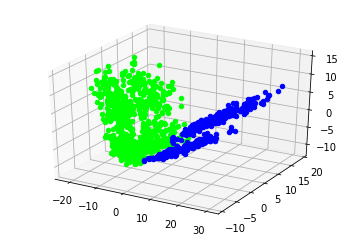

In [45]:
c=0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])